## Libraries

In [1]:
# linear algebra and data processing
import numpy as np
import pandas as pd 

#data visualisations
import seaborn as sns
import matplotlib.pyplot as plt

# preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

# statistics
from scipy import stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# models + accuracy metrics
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# saving models
import pickle
import gzip

# ignore warnings
import warnings
warnings.filterwarnings(action="ignore")

# datasets path
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/rossmann-store-sales/test.csv
/kaggle/input/rossmann-store-sales/sample_submission.csv
/kaggle/input/rossmann-store-sales/store.csv
/kaggle/input/rossmann-store-sales/train.csv


## Data

In [2]:
# data
na_value=['',' ','nan','Nan','NaN','na', '<Na>']
train = pd.read_csv('/kaggle/input/rossmann-store-sales/train.csv', na_values=na_value)
test = pd.read_csv('/kaggle/input/rossmann-store-sales/test.csv', na_values=na_value)
store = pd.read_csv('/kaggle/input/rossmann-store-sales/store.csv', na_values=na_value)
submission = pd.read_csv('/kaggle/input/rossmann-store-sales/sample_submission.csv', na_values=na_value)

print('train set shape:', train.shape)
print('test set shape:', test.shape)
print('store set shape:', store.shape)

train set shape: (1017209, 9)
test set shape: (41088, 8)
store set shape: (1115, 10)


In [3]:
# merge the train/test sets with the stores set
full_train = pd.merge(left = train, right = store, how = 'inner', left_on = 'Store', right_on = 'Store')
full_test = pd.merge(left = test, right = store, how = 'inner', left_on = 'Store', right_on = 'Store')
print(full_train.shape)
print(full_test.shape)

(1017209, 18)
(41088, 17)


In [4]:
# quick peak
full_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

In [5]:
full_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 0 to 41087
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Id                         41088 non-null  int64  
 1   Store                      41088 non-null  int64  
 2   DayOfWeek                  41088 non-null  int64  
 3   Date                       41088 non-null  object 
 4   Open                       41077 non-null  float64
 5   Promo                      41088 non-null  int64  
 6   StateHoliday               41088 non-null  object 
 7   SchoolHoliday              41088 non-null  int64  
 8   StoreType                  41088 non-null  object 
 9   Assortment                 41088 non-null  object 
 10  CompetitionDistance        40992 non-null  float64
 11  CompetitionOpenSinceMonth  25872 non-null  float64
 12  CompetitionOpenSinceYear   25872 non-null  float64
 13  Promo2                     41088 non-null  int

## Preprocessing

In [6]:
def preprocess_data(full_train, full_test):
    
    # '''preprocessing'''
    global train_features, test_features, train_target, categorical, numerical

    # train and target features
    train_features = full_train.drop(['Sales', 'Customers'], axis = 1) #drop the target feature + customers (~ will not be used for prediction)
    train_target  = full_train[['Sales']]
    test_features = full_test.drop(['Id'], axis = 1) #drop id, it's required only during submission

    #feature generation + transformations
    train_features['Date'] = pd.to_datetime(train_features.Date)
    train_features['Month'] = train_features.Date.dt.month.to_list()
    train_features['Year'] = train_features.Date.dt.year.to_list()
    train_features['Day'] = train_features.Date.dt.day.to_list()
    train_features['WeekOfYear'] = train_features.Date.dt.weekofyear.to_list()
    train_features['DayOfWeek'] = train_features.Date.dt.dayofweek.to_list()
    train_features['weekday'] = 1        # Initialize the column with default value of 1
    train_features.loc[train_features['DayOfWeek'] == 5, 'weekday'] = 0
    train_features.loc[train_features['DayOfWeek'] == 6, 'weekday'] = 0
    # train_features = train_features.drop(['Date'], axis = 1)
    train_features = train_features.drop(['Store'], axis = 1)

    test_features['Date'] = pd.to_datetime(test_features.Date)
    test_features['Month'] = test_features.Date.dt.month.to_list()
    test_features['Year'] = test_features.Date.dt.year.to_list()
    test_features['Day'] = test_features.Date.dt.day.to_list()
    test_features['WeekOfYear'] = test_features.Date.dt.weekofyear.to_list()
    test_features['DayOfWeek'] = test_features.Date.dt.dayofweek.to_list()
    test_features['weekday'] = 1        # Initialize the column with default value of 1
    test_features.loc[test_features['DayOfWeek'] == 5, 'weekday'] = 0
    test_features.loc[test_features['DayOfWeek'] == 6, 'weekday'] = 0
    # test_features = test_features.drop(['Date'], axis = 1)
    test_features = test_features.drop(['Store'], axis = 1)


    # numerical and categorical columns (train set)
    categorical = []
    numerical = []
    timestamp = []

    for col in train_features.columns:
        if train_features[col].dtype == object:
            categorical.append(col)
        elif train_features[col].dtype in ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']:
            numerical.append(col)
        else:
            timestamp.append(col)

    # Keep selected columns only
    my_cols = categorical + numerical + timestamp
    train_features = train_features[my_cols].copy()
    test_features = test_features[my_cols].copy()
    features = pd.concat([train_features, test_features]) #merge the features columns for uniform preprocessing

    # change dtypes for uniformity in preprocessing
    features.CompetitionOpenSinceMonth = features.CompetitionOpenSinceMonth.astype('Int64') 
    features.CompetitionOpenSinceYear = features.CompetitionOpenSinceYear.astype('Int64')
    features.Promo2SinceWeek = features.Promo2SinceWeek.astype('Int64') 
    features.Promo2SinceYear = features.Promo2SinceYear.astype('Int64')
    features["StateHoliday"].loc[features["StateHoliday"] == 0] = "0"



    # ''' actual preprocessing: the mighty pipeline '''
    # numeric
    for col in ['CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear']:
        features[col] = features[col].fillna((int(features[col].mean()))) 
    features.PromoInterval = features.PromoInterval.fillna(features.PromoInterval.mode()[0])
    features.Open = features.Open.fillna(features.Open.mode()[0])
    features = pd.get_dummies(features, columns=['StoreType', 'Assortment', 'PromoInterval', 'StateHoliday'], drop_first=True)
    scaler = RobustScaler()
    c = ['DayOfWeek', 'Open', 'Promo', 'SchoolHoliday', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
    'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'WeekOfYear', 'Month', 'Year', 'Day', 'WeekOfYear', 'weekday']
    features[numerical] = scaler.fit_transform(features[numerical].values)


    return features

In [7]:
features = preprocess_data(full_train, full_test)
features = features.drop(['Date'], axis = 1)
features.head()

,DayOfWeek,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,...,StoreType_b,StoreType_c,StoreType_d,Assortment_b,Assortment_c,"PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",StateHoliday_a,StateHoliday_b,StateHoliday_c
0,0.25,0.0,1.0,1.0,-0.172078,0.666667,0.0,-1.0,0.0,0.0,...,0,1,0,0,0,1,0,0,0,0
1,0.00,0.0,1.0,1.0,-0.172078,0.666667,0.0,-1.0,0.0,0.0,...,0,1,0,0,0,1,0,0,0,0
2,-0.25,0.0,1.0,1.0,-0.172078,0.666667,0.0,-1.0,0.0,0.0,...,0,1,0,0,0,1,0,0,0,0
3,-0.50,0.0,1.0,1.0,-0.172078,0.666667,0.0,-1.0,0.0,0.0,...,0,1,0,0,0,1,0,0,0,0
4,-0.75,0.0,1.0,1.0,-0.172078,0.666667,0.0,-1.0,0.0,0.0,...,0,1,0,0,0,1,0,0,0,0


In [8]:
# reconstruct train and test sets
def reconstruct_sets(features):
    global x_train, x_val, y_train, y_val
    # global train_set
    # original train and test sets
    x_train = features.iloc[:len(train_features), :]
    x_test = features.iloc[len(train_features):, :]
    y_train = train_target
    # train_set = pd.concat([x_train, y_train], axis=1)

    # updated train and validation sets
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = .20, random_state = 0)


    return x_train, x_val, y_train, y_val, x_test

In [9]:
x_train, x_val, y_train, y_val, x_test = reconstruct_sets(features)
# log transformation on target variable
y_train = np.log1p(y_train['Sales'])
y_val = np.log1p(y_val['Sales'])
x_train.shape, x_val.shape, y_train.shape, y_val.shape, x_test.shape

((813767, 25), (203442, 25), (813767,), (203442,), (41088, 25))

## Modelling 

In [22]:
features.to_csv('features.csv')

In [10]:
# RandiomForestRegressor

#fitting
clf = RandomForestRegressor(n_estimators = 15)
clf.fit(x_train, y_train)

# validation
y_pred = clf.predict(x_val)
mean_squared_error(y_val, y_pred)
print("Mean squared error for RF on validation data =", mean_squared_error(y_val, y_pred))
print("Mean absolute error for RF on validation data =", mean_absolute_error(y_val, y_pred))

Mean squared error for RF on validation data = 0.018773762380366082
Mean absolute error for RF on validation data = 0.07595471046043134


In [11]:
# LinearRegression

#fitting
regressor = LinearRegression()
regressor.fit(x_train, y_train)

#validation
# scores = cross_val_score(estimator = regressor, X = x_train, y = y_train, cv = 5)
regressor_pred = regressor.predict(x_val)
print("Mean squared error for sLR on validation data =", mean_squared_error(y_val, regressor_pred))
print("Mean absolute error for SLR on validation data =", mean_absolute_error(y_val, regressor_pred))

Mean squared error for sLR on validation data = 0.11848353838195072
Mean absolute error for SLR on validation data = 0.2527261289148486


In [12]:
# ExtremeBooster

#fitting
xgb = XGBRegressor(random_state = 42)
xgb.fit(x_train, y_train)

# validation
# scores = cross_val_score(estimator = xgb, X = x_train, y = y_train, cv = 5)
xgb_pred = xgb.predict(x_val)
print("Mean absolute error for xgb on validation data =", mean_absolute_error(y_val, xgb_pred))
print("Mean squared error for xgb on validation data =", mean_squared_error(y_val, xgb_pred))

Mean absolute error for xgb on validation data = 0.12452815574403905
Mean squared error for xgb on validation data = 0.03187670561363815


In [13]:
# GradientBooster

#fitting
gdb = GradientBoostingRegressor(random_state = 5)
gdb = gdb.fit(x_train, y_train)

#validation
gdb_pred = gdb.predict(x_val)
print("Mean absolute error for gdb on validation data =", mean_absolute_error(y_val, gdb_pred))
print("Mean squared error for gdb on validation data =", mean_squared_error(y_val, gdb_pred))

Mean absolute error for gdb on validation data = 0.2217410065237111
Mean squared error for gdb on validation data = 0.0966456895614806


Text(0.5, 1.0, 'MSE scores in the 4 models')

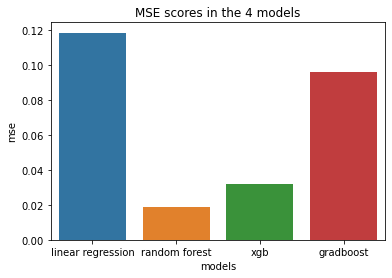

In [14]:
# Models performance
data = {'models':['linear regression', 'random forest', 'xgb', 'gradboost'], 
        'mse':[0.11848353838195493, 0.018760600706471536, 0.03187670561363815, 0.09603717825043254 ],
        'mae':[0.2527261289148881, 0.2527261289148881, 0.12452815574403905, 0.2212165651646456]}
performance = pd.DataFrame(data, columns = ['models', 'mse', 'mae'])
sns.barplot(x = performance.models,  y = performance.mse)
plt.title('MSE scores in the 4 models')

Text(0.5, 1.0, 'MAE scores in the 4 models')

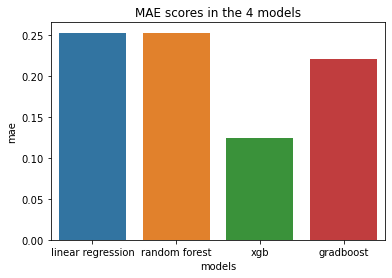

In [15]:
sns.barplot(x = performance.models,  y = performance.mae)
plt.title('MAE scores in the 4 models')

Random Forest and XGB have a good performance.
Going the MSE way: RandomForest is the ideal one.

In [16]:
# #stacking the models
# class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
#     def __init__(self, models):
#         self.models = models
        
#     # we define clones of the original models to fit the data in
#     def fit(self, x_train, y_train):
#         self.models_ = [clone(x) for x in self.models]
        
#         # Train cloned base models
#         for model in self.models_:
#             model.fit(x_train, y_train)

#         return self
    
#     #Now we do the predictions for cloned models and average them
#     def predict(self, x_train):
#         predictions = np.column_stack([
#             model.predict(x_train) for model in self.models_
#         ])
#         return np.mean(predictions, axis=1)


# # our first fit
# averaged_models = AveragingModels(models = (regressor, clf, lgb, xgb, gdb))

# score = rmsle_cv(averaged_models)
# print('Averaged base models score: mean = ', score.mean(), 'std  =', score.std())

In [17]:
# save the model
def save_zipped_pickle(obj, filename, protocol=-1):
    with gzip.open(filename, 'wb') as f:
        pickle.dump(obj, f, protocol)
        
save_zipped_pickle(clf, 'compressed.pkl') #rf
save_zipped_pickle(clf, 'compressed_xgb.pkl') #xgb
save_zipped_pickle(clf, 'compressed_gb.pkl') #gb

In [18]:
# # reload zipped pickle
# def load_zipped_pickle(filename):
#     with gzip.open(filename, 'rb') as f:
#         loaded_object = pickle.load(f)
#         return loaded_object

## Predictions

In [19]:
# make predictions using the random forest model
final_pred = clf.predict(x_test)
final_pred.shape

(41088,)

In [20]:
'''reconstruct a df with StoreID, date and Sales columns using the predcitions and the test set then save it as a csv file'''

sub = full_test[['Id']]
back = np.expm1(final_pred)
sub['Sales'] = back
sub['Date'] = full_test.Date.to_list()
sub['Store'] = full_test.Store.to_list()
sub.to_csv('sub_plot.csv', index = False)

## Pred Plot

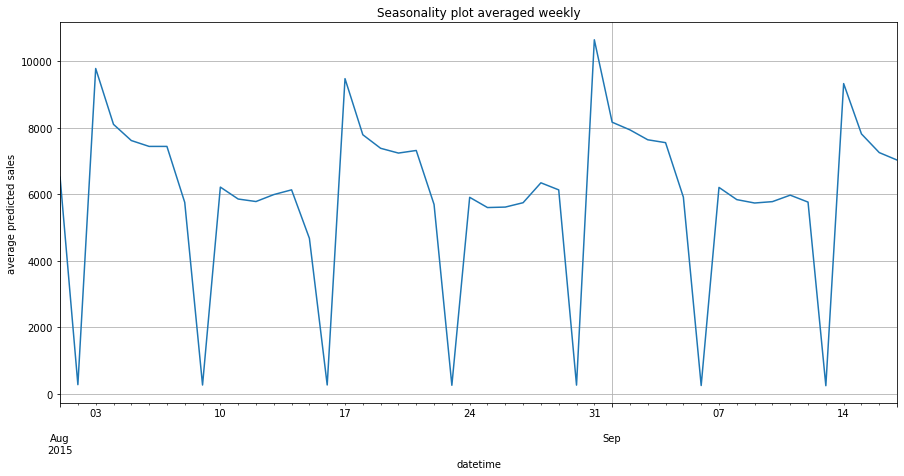

In [21]:
time_data = sub[['Date', 'Sales']]
time_data['datetime'] = pd.to_datetime(time_data['Date'])
time_data = time_data.set_index('datetime')
time_data = time_data.drop(['Date'], axis = 1)
monthly_time_data = time_data.Sales.resample('D').mean() 
plt.figure(figsize = (15,7))
plt.title('Seasonality plot averaged weekly')
plt.ylabel('average predicted sales')
monthly_time_data.plot()
plt.grid()

The trends across the 12 months cannot be observed given the predictions is 2 months long. Nevertheless, the plot is informative enough. The trend observed captures the low sales during Sundays (2nd, 9th, 16th, 23rd, 30th August and 6th, 13th September.) From the train data, it is observed that most stores are closed on Sundays, hence the predicted sales for Sundays. The sales peak on Mondays then flatten during the remaining 5 days of the week.